In [5]:
import numpy as np
from scipy import sparse
from scipy.linalg import solve
import matplotlib.pyplot as plt
from PIL import Image
from copy import deepcopy
from itertools import product
import scipy.ndimage

In [6]:
class ALS(object):
    
    def __init__(self, k=10, lambda_ = 10, max_iter=10, tol=1e-5, missed_val = 'NaN', print_iter=False):
        self._k = k
        self._lambda = lambda_
        self._max_iter = max_iter
        self._missed_val = missed_val
        self._tol = tol
        self._print_iter = print_iter
        self._errors = []
    
    def fit(self, ratings):
        #initial assigning of factors X, Y
        X, Y = np.abs(np.random.rand(self._k, ratings.shape[0])), np.abs(np.random.rand(self._k, ratings.shape[1]))
            
        for i in range(self._max_iter):
            column_diff_norm = 0
            if self._print_iter:
                print(i)

            #flag shows that X and Y changed much, so we should not stop
            flag = True

            for j in range(ratings.shape[0]):
                #take row in matrix of observations with which we will work
                row = ratings.getrow(j).toarray().ravel()

                #find arguments of elemnts in row which were not missed
                args = []
                if self._missed_val == 'NaN':
                    args = np.argwhere(~np.isnan(row)).T[0]
                else:
                    args = np.argwhere(row != self._missed_val).T[0]

                #create matrices to save temporary results
                summation_inv = np.zeros((self._k, self._k))
                summation = np.zeros((self._k, 1))

                #for every non-nan element in row we take corresponding column of Y and make manipulations
                for arg in args:
                    summation_inv = summation_inv + (Y[:, arg].reshape(-1,1)).dot(Y[:, arg].reshape(1, -1))
                    summation = summation + row[arg] * Y[:, arg].reshape(-1,1)

                #update the corresponding column of X
                new_X = solve(summation_inv + self._lambda * np.eye(self._k), summation)
                column_diff_norm += np.linalg.norm(X[:,j] - new_X) / np.linalg.norm(X[:,j])
                X[:,j] = new_X.reshape(-1,)

            #repeat everything for matrix Y
            for j in range(ratings.shape[1]):
                #take column in matrix of observations with which we will work
                column = ratings.getcol(j).toarray().ravel()

                #find arguments of elemnts in column which were not missed
                args = []
                if self._missed_val == 'NaN':
                    args = np.argwhere(~np.isnan(column)).T[0]
                else:
                    args = np.argwhere(column != self._missed_val).T[0]

                #create matrices to save temporary results
                summation_inv = np.zeros((self._k, self._k))
                summation = np.zeros((self._k, 1))

                #for every non-nan element in row we take corresponding column of Y and make manipulations
                for arg in args:
                    summation_inv = summation_inv + (X[:, arg].reshape(-1,1)).dot(X[:, arg].reshape(1, -1))
                    summation = summation + column[arg] * X[:, arg].reshape(-1,1)

                #update the corresponding column of Y
                new_Y = solve(summation_inv + self._lambda * np.eye(self._k), summation)
                column_diff_norm += np.linalg.norm(Y[:,j] - new_Y) / np.linalg.norm(Y[:,j])
                Y[:,j] = new_Y.reshape(-1)

            self._errors.append(column_diff_norm)
            if column_diff_norm < 1e-5:
                break

        #save the results as the attribute of class
        self._X = X
        self._Y = Y
    
    def get_factors(self):
        return self._X, self._Y
    
    def continue_fit(self, X, Y):
        pass
        
    def predict(self):
        return (self._X.T).dot(self._Y)
    
    def get_errors(self):
        return self._errors

In [7]:
def plot_many_pics(matrix, ranks, lambdas, iterations, missed_val = 'NaN'):
    triples = product(ranks, lambdas, iterations)
    
    
    epsilons = np.exp(np.linspace(0.01, 4, 25))
    epsilons = 1 / epsilons
    fig = plt.figure(figsize=(20, 20))

    for i , epsilon in enumerate(epsilons):

        img_appr, eps_rank = approximate(img, epsilon)
        ax = fig.add_subplot(5, 5, i + 1)
        ax.imshow(img_appr, cmap=plt.cm.gray)
        ax.set_title("eps = {}, rank = {}".format(epsilon.round(3), eps_rank))

In [8]:
img = np.array(Image.open('test.png'), dtype=np.float64)[:, :, 0]
img[img == 0] = 100

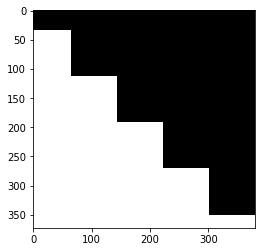

In [9]:
plt.imshow(img, cmap='gray')
plt.show()

In [10]:
np.linalg.matrix_rank(img)

5

In [11]:
rows = np.array([], dtype=np.int)
cols = np.array([], dtype=np.int)

k_vals = np.array([-100, -50, -25, -10, -5, 0, 5, 10, 25, 50, 100, 1, 2, 3, -1, -2, -3], dtype=np.int)

for k in k_vals:
    A = sparse.eye(m=img.shape[0], n=img.shape[1], k=k)
    rows_ind, cols_ind = A.nonzero()
    rows = np.append(rows, rows_ind)
    cols = np.append(cols, cols_ind)
    
X = sparse.csr_matrix((img[(rows, cols)], (rows, cols)), shape=img.shape)

In [12]:
diags = np.arange(-99, 100, 10)
X = sparse.diags(diagonals=np.ones(diags.size), offsets=diags, shape=(100, 100))
X

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements (20 diagonals) in DIAgonal format>

In [13]:
a = ALS(k=5, lambda_=0.01, max_iter=20, missed_val=0)

In [14]:
a.fit(X)

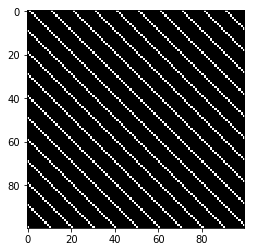

In [15]:
plt.imshow(X.toarray(), cmap='gray')
plt.show()

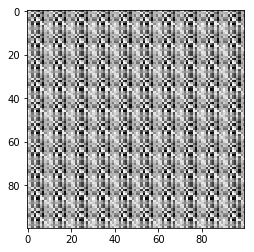

In [16]:
plt.imshow(a.predict(), cmap='gray')
plt.show()

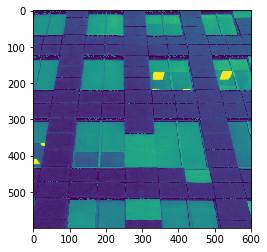

In [18]:
img = np.array(Image.open('sk.png'), dtype=np.float64)[:, :, 0]
img[img == 0] = 100
plt.imshow(img)
plt.show()

In [19]:
# random init
num = img.size // 10

np.random.seed(25)
row_ind = np.random.randint(0, img.shape[0], size=num)
col_ind = np.random.randint(0, img.shape[1], size=num)

row_ind = np.append(row_ind, np.arange(img.shape[0]))
col_ind = np.append(col_ind, np.arange(img.shape[0]))

X = sparse.csr_matrix((img[(row_ind, col_ind)], (row_ind, col_ind)), shape=img.shape)

for i in range(1, 5):
    X[X == 100 * i] = 100
    X[X == 255 * i] = 255

In [20]:
a = ALS(k=100, lambda_= 0.1, max_iter=20, missed_val=0)

In [21]:
a.fit(X)

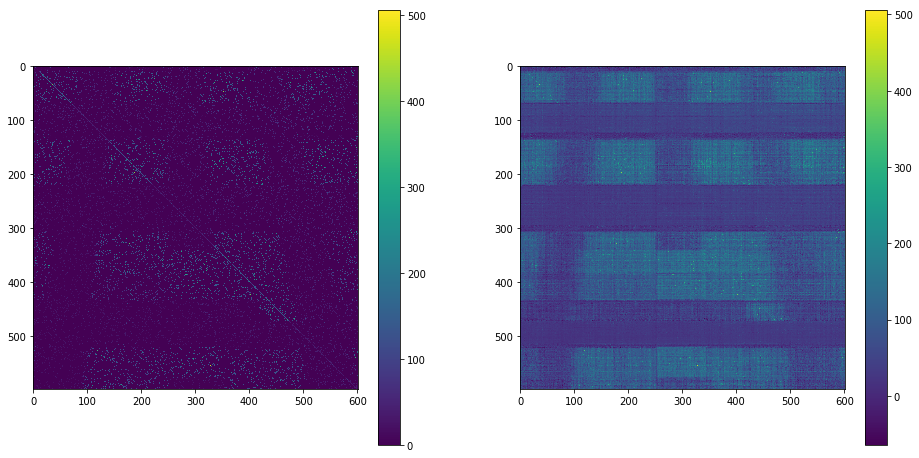

In [22]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = a.predict()
plt.imshow(A)
plt.colorbar()
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


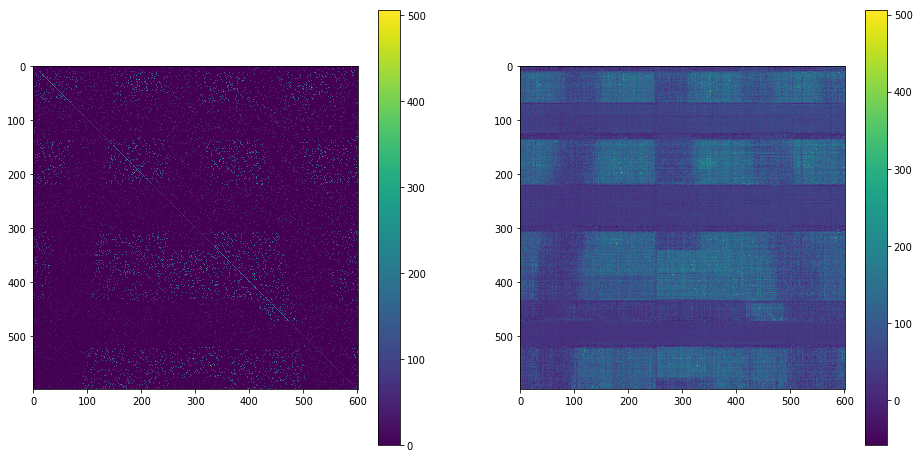

In [431]:
a = ALS(k=100, lambda_= 0.1, max_iter=100, missed_val=0, print_iter=True)
a.fit(X)
plt.figure(figsize=(16, 8))

plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
A = a.predict()
plt.imshow(A)
plt.colorbar()
plt.show()

In [73]:
def approximate(img, eps): 
    n = 400
    u, s, v = np.linalg.svd(img)
    print(u.shape, s.shape, v.shape)
    #n = -1
    img_appr = np.array(img)
    
    while np.linalg.norm(img_appr - img) / np.linalg.norm(img) < eps:
        img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
        n -= 1
    n += 2
    eps_rank = n
    img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
    return img_appr, eps_rank

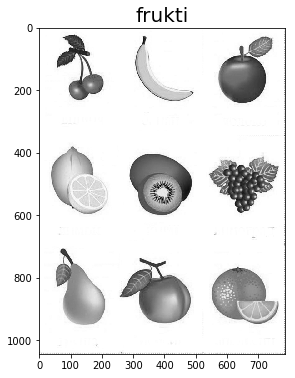

In [74]:
img = np.array(Image.open('5.png'), dtype=np.float64)
plt.figure(figsize=(14,6))
plt.subplot(111)
plt.title('frukti', fontsize=20)
plt.imshow(img, cmap='gray')
plt.show()

In [75]:
np.linalg.matrix_rank(img)

775

In [76]:
new_img, rank = approximate(img, 0.03)

(1044, 1044) (787,) (787, 787)


In [77]:
np.linalg.matrix_rank(new_img)

70

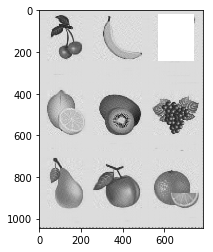

In [78]:
new_img[20:245,570:745] = np.nan
plt.imshow(new_img, cmap=plt.cm.gray)
plt.show()

In [79]:
np.linalg.matrix_rank(new_img)

C:\Users\Liliya\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\linalg\linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)


0

In [80]:
X = sparse.coo_matrix(new_img)

In [81]:
a = ALS(k=90, lambda_=0.01, max_iter=20, missed_val='NaN', print_iter=True)
a.fit(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


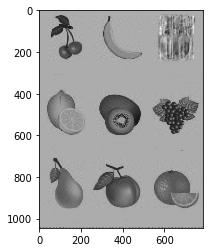

In [82]:
plt.imshow(a.predict(), cmap='gray')
plt.show()

In [83]:
a = ALS(k=90, lambda_=0.1, max_iter=20, missed_val='NaN', print_iter=True)
a.fit(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


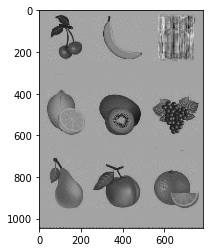

In [84]:
plt.imshow(a.predict(), cmap='gray')
plt.show()

In [85]:
a = ALS(k=90, lambda_=1, max_iter=20, missed_val='NaN', print_iter=True)
a.fit(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


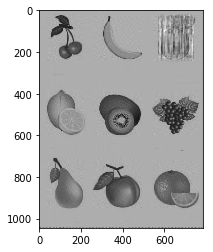

In [86]:
plt.imshow(a.predict(), cmap='gray')
plt.show()

In [87]:
a = ALS(k=90, lambda_=0.5, max_iter=30, missed_val='NaN', print_iter=True)
a.fit(X)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


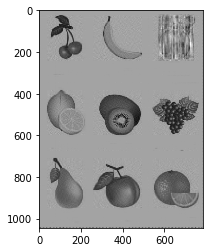

In [88]:
plt.imshow(a.predict(), cmap='gray')
plt.show()